In [1]:
from __future__ import division

import glob
import os
import numpy as np
import pandas as pd
import pylab as pl
import random
import sounddevice as sd

from scipy.io import wavfile
import matplotlib.pyplot as plt
import python_speech_features
from python_speech_features import mfcc
from sklearn.cluster import MiniBatchKMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
#from adjustText import adjust_text
from collections import Counter
from scipy.io.wavfile import write
from sklearn.cluster import AgglomerativeClustering

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures

# import librosa
import pydub
from pydub import AudioSegment
import soundfile as sf
import tempfile
from pydub.utils import which
from scipy.io.wavfile import write
import scipy 
import warnings 
import samplerate 
# a lot faster to use
# https://stackoverflow.com/questions/29085268/resample-a-numpy-array/52347385#52347385

AudioSegment.converter = which("ffmpeg")
%matplotlib inline

# TODO: put in requirements.txt --> pip install list 
# pip install pyAudioAnalysis, tqdm, eyed3

In [2]:
# Returns all clip indexes within a cluster
def get_clip_indexes(cluster_label, clusters):
    clips_i = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_label:
            clips_i.append(i)
    return clips_i

# Plays a random clip in a given cluster
def play_random_clip_in_cluster(index, clusters, option='cluster'):
    assert(option == 'cluster' or option == 'clip')
    if option == 'clip':
        index = find_cluster(index, clusters) # Get cluster index
    
    clips = get_clip_indexes(index, clusters)
    clip_i = clips[random.randint(0, len(clips) - 1)]
    print('Playing clip index %d ' % clip_i)
    play_clip(clip_i)
        
# Returns the cluster label that a clip belongs to
def find_cluster(clip_index, clusters):
    return clusters[clip_index]

# Plays an audio clip given the clip index
def play_clip(clip_index):
    samples = shorter_clips[clip_index]
    sd.play(samples, samplerate)

# Flattens a given list
def list_flatten(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

# Saves clip as a wav file
def save_clip(filename, wav_array):
#     assert('.' not in filename)
    write(filename + '.wav', samplerate, wav_array)
    
# Saves all clips to a directory
def save_clips_to_dir(shorter_clips, dirname):
    for i, clip in enumerate(shorter_clips):
        save_clip(dirname + '/%d' % i, clip) 
        
# def make_bird_species_list(bird_species_list, bird_name, index): 
#     "Define bird_species outside of function"
#     if bird_name not in bird_species_list[index]:
#         bird_species[index].append(bird_name)
# #     return bird_species_list
            
def convert_mp3_to_wav(mp3_path, sr=44100, mono=True, overwrite=False, dtype='float32'): 
    # Need to change sample rate to 44.1kHz if using audiomoths
    # since mono=True by default, unless you pass mono=False, 
    # this function will save the wav as mono
#     print("entering convert_mp3_to_wav")
    """
    Parts of code from 
    https://github.com/bill317996/Audio-to-midi/blob/master/cfp.py
    """
    
#     warnings.warn("deprecated", DeprecationWarning)
    
    # in case there is an .MP3
    assert mp3_path.lower().endswith('.mp3'), 'filename indicates not mp3'
    wav_path_to_write = os.path.splitext(mp3_path)[0] + '.wav'
    if not overwrite and os.path.exists(wav_path_to_write):
        return
    
    mp3 = AudioSegment.from_file(mp3_path)
    
    _, temp_path = tempfile.mkstemp() 
    mp3.export(temp_path, format='wav')
    del mp3
    x, fs = sf.read(temp_path)
    os.remove(temp_path)
    
    if mono and len(x.shape)>1: 
        x = np.mean(x, axis = 1) 
    if sr:
        x = scipy.signal.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)
    write(wav_path_to_write, fs, x)
    return x, fs    


def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_file(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

## Load Audio Data

In [3]:
def find_n_second_multiples_and_filenames(dir_path, n): 
    """ 
    dir_path (path): path of a directory with desired files
    n (int): split data into n-second clips
    
    #TODO: reduce the numpy array (wav_data)
    """
    wav_data = []
    allfilenames = []
    # entire filename 
    timestamp = []

    for filename in os.listdir(dir_path):
        filepath = os.path.join(dir_path, filename)
        print(filepath)
        
        if filepath == ".DS_Store": 
            pass 
        elif filename.endswith(".mp3") or filename.endswith(".MP3"): 
            data, sr = convert_mp3_to_wav(filepath)
        elif filename.endswith(".wav") or filename.endswith(".WAV"):
            sr, data = wavfile.read(filepath)
            fs = 44100
            data = samplerate.resample(data, fs/sr, 'sinc_best')
            #data = scipy.signal.resample_poly(data, sr, fs)
            sr = fs
            
        num_samples_in_n_seconds =  n  * sr 
        length_data = len(data)
        length_in_seconds = length_data / sr 
        
        if length_data < num_samples_in_n_seconds: 
            pass
        
        elif length_data > num_samples_in_n_seconds: 
            data = data[:-(length_data % num_samples_in_n_seconds)]
            num_of_n_clips = int(np.floor(length_data / num_samples_in_n_seconds))
            
            for i in range(num_of_n_clips): 
#                 allfilenames.append(list_file_name[0]+list_file_name[1])
                allfilenames.append(filename)
                data_n_seconds = data[i*num_samples_in_n_seconds:(i+1)*num_samples_in_n_seconds]
                timestamp.append([i*n,(i+1)*n])
                wav_data.append(data_n_seconds)

        else: #length_data == num_samples_in_n_seconds: 
            allfilenames.append(filename)
            wav_data.append(data)
            
    return wav_data, allfilenames, timestamp

In [6]:
dir_path = '/Volumes/Elements/Test/Data/'
# dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
# dir_path = '/Users/Jacob/Desktop/BioacousticsProject/AudioMothData/GRABADOR-SDZG-AM-15/'
# dir_path = '/Volumes/Elements/Mixed_AM_Dataset2_shorter/'

shorter_clips, file_names, timestamp = find_n_second_multiples_and_filenames(dir_path, 10)
print(file_names)
print(len(file_names))
print(timestamp)
print(len(timestamp))

/Volumes/Elements/Test/Data/XC22019 - Blue-crowned Trogon - Trogon curucui.wav
/Volumes/Elements/Test/Data/XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus.wav
/Volumes/Elements/Test/Data/XC22072 - Sapphire-spangled Emerald - Amazilia lactea.wav
/Volumes/Elements/Test/Data/XC496773 - White-lined Antbird - Myrmoborus lophotes.wav
/Volumes/Elements/Test/Data/XC496790 - Great Jacamar - Jacamerops aureus.wav
/Volumes/Elements/Test/Data/XC91439 - Black-tailed Tityra - Tityra cayana.wav
/Volumes/Elements/Test/Data/XC91669 - Cabanis's Spinetail - Synallaxis cabanisi.wav
['XC22019 - Blue-crowned Trogon - Trogon curucui.wav', 'XC22019 - Blue-crowned Trogon - Trogon curucui.wav', 'XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus.wav', 'XC496773 - White-lined Antbird - Myrmoborus lophotes.wav', 'XC496773 - White-lined Antbird - Myrmoborus lophotes.wav', 'XC496773 - White-lined Antbird - Myrmoborus lophotes.wav', 'XC496790 - Great Jacamar - Jacamerops aureus.wav', 'XC49

# Spectrograms

In [71]:
def plot_spectrogram(samplerate, shorter_clips, clip_index, separate_channels=False):
    left_channel = shorter_clips[clip_index][:, 0]
    right_channel = shorter_clips[clip_index][:, 1]
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Clip #%d (Left Channel)' % clip_index)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Clip #%d (Right Channel)' % clip_index)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Clip #%d' % clip_index)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()
    
def plot_spectrogram_of_cluster(samplerate, shorter_clips, cluster_i, clusters, separate_channels=False):
    clip_indexes = get_clip_indexes(cluster_i, clusters)
    
    left_channel = shorter_clips[clip_indexes[0]][:, 0]
    right_channel = shorter_clips[clip_indexes[0]][:, 1]
    
    for i in range(1, len(clip_indexes)):
        left_channel = np.append(left_channel, shorter_clips[clip_indexes[i]][:, 0])
        right_channel = np.append(right_channel, shorter_clips[clip_indexes[i]][:, 1])
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Cluster #%d (Left Channel)' % cluster_i)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Cluster #%d (Right Channel)' % cluster_i)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Cluster #%d' % cluster_i)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()

# Feature Extraction

In [7]:
# TODO: Add a way to select and evaluate features
samplerate = 44100
def extract_features(shorter_clips, mfcc_only=False, mono=False):
    feat_clips = []

    print('Extracting features for each of the %d audio clips' % len(shorter_clips))
    for clip in shorter_clips:
        print("clip", clip)
        if mono == False:
            clip = clip[:, 0] + clip[:, 1] # Merging left and right channels

        mfcc_feat=None
        if mfcc_only:
            mfcc_feat = mfcc(clip, samplerate, winlen=0.023, nfft = 1024).flatten()

        else:
            mfcc_feat = ShortTermFeatures.feature_extraction(clip, samplerate, 0.050*samplerate, 0.025*samplerate)
            print('')
            print(mfcc_feat[1])

        # Append the features
        if mfcc_only:
            feat_clips.append(mfcc_feat)
        else:
            feat_clips.append(list_flatten(mfcc_feat[0]))

    print('done')
    return feat_clips
    
# Set mfcc_only to True to shorten runtime
mfcc_clips = extract_features(shorter_clips, mfcc_only=True, mono=True)
# mfcc_clips = extract_features(shorter_clips, mfcc_only=True, mono=True)
#all_feat_clips = extract_features(shorter_clips)
print(shorter_clips)
print(len(mfcc_clips))
print(mfcc_clips)
print(mfcc_clips[0].shape)


Extracting features for each of the 14 audio clips
clip [ 0.          0.          0.         ... -0.07061823 -0.04971259
 -0.02154593]
clip [ 0.01214649  0.04666091  0.07174726 ... -0.13351686 -0.06414571
  0.03042402]
clip [ 0.          0.          0.         ... -0.04003615 -0.03369429
 -0.00735188]
clip [0.         0.         0.         ... 0.0881493  0.05867019 0.07281865]
clip [ 0.06106231  0.03762175  0.01144261 ... -0.04041994 -0.03492397
 -0.02832239]
clip [-0.01542564  0.01090988  0.03342442 ...  0.02018262  0.01374718
 -0.00428085]
clip [0.         0.         0.         ... 0.01384665 0.02716949 0.04880293]
clip [ 0.06546489  0.05930602  0.00584721 ...  0.02948927  0.0114844
 -0.02627126]
clip [ 0.          0.          0.         ... -0.0010984  -0.02581809
 -0.03063946]
clip [-0.01297012  0.01306163  0.03207391 ...  0.00265377 -0.06069579
 -0.08151905]
clip [-0.03206394  0.04420605  0.08021843 ... -0.02313206  0.01238991
  0.04006977]
clip [ 0.03109726 -0.00442494 -0.0373535

# Clustering

In [8]:
dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

X = pos

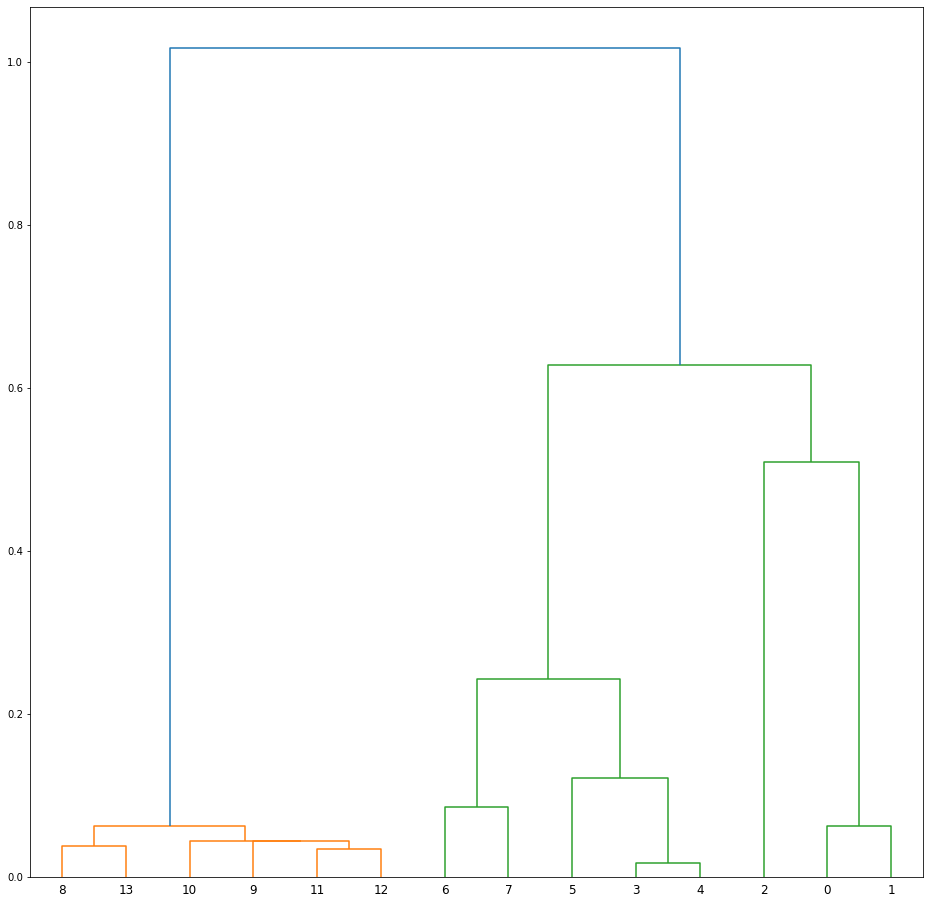

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(len(X))

plt.figure(figsize=(16, 16))
dendro = dendrogram(linked,
#             p=7,
            orientation='top',
            #labels=labelList,
            truncate_mode='level',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [75]:
def cluster_plot(pos, title='', without_labels=False, width=20, height=20, savepath=''):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    labels = range(len(shorter_clips))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'], cluster_df.loc[i, 'y'], cluster_df.loc[i,'labels'], size=10)) 

        #adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

#### Choose number of clusters
Note the the number of clusters needs to be less than the length of mfcc_clips

In [10]:
print(len(mfcc_clips))

14


In [11]:
# Chose 134 from the number of bird species in the XenoCanto data
n_clusters = 3

# Fit clustering model
clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(mfcc_clips)

In [ ]:
# savepath = '/Volumes/Elements/dendrogram'
plt.savefig(savepath, dpi=200, bbox_inches="tight")

In [ ]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'PCA Cluster Plot', without_labels=True, savepath='/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/pca.png')

In [ ]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(mfcc_clips)
mds = TSNE(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'TSNE Cluster Plot', without_labels=True, savepath='/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/tsne.png')

# Cluster Interpretation

In [12]:
# Prints: (Cluster number, count of clips in cluster)
Counter(clusters).most_common()

[(1, 6), (0, 5), (2, 3)]

In [13]:
play_random_clip_in_cluster(6, clusters) # Play random clip in a cluster

ValueError: empty range for randrange() (0,0, 0)

In [139]:
sd.stop() # Stop playing

In [140]:
# Can assign a label to each cluster here
#cluster_names = ['quiet', 'loud', 'quiet', 'rain', 'birds', 'crickets', 'birds', 'quiet', 'quiet', 'loud']

In [219]:
play_clip(36) 

IndexError: list index out of range

## Save clusters of audio files

In [79]:
dirname = '/Volumes/Elements/Test/Clusters/'
# dirname = '/Volumes/Elements/Test/Clusters/'

for i in range(len(np.unique(clusters))):
    os.mkdir(dirname + 'cluster_%d' % i)
    for j in get_clip_indexes(i, clusters):
        save_clip(dirname + 'cluster_%d/%s' % (i, file_names[j]), shorter_clips[j])

In [80]:
print(len(np.unique(clusters)))
print(np.unique(clusters))
print(get_clip_indexes(i, clusters))
print(len(clusters))
print(len(file_names))

3
[0 1 2]
[0, 1, 2]
14
14


## Analyze clusters 
Find the total number of bird species in cluster and also the list of dictionary of each file name corresponding to each cluster number

In [14]:
print(file_names)

num_bird_species = []
cluster_list_ordered = []

for i in range(len(np.unique(clusters))): 
    cluster_set = set()
    for j in get_clip_indexes(i, clusters):
        cluster_list_ordered.append(i)
        bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
#         print(bird_species)
#         print(type(bird_species))
        cluster_set.add(bird_species)
    num_bird_species.append(len(cluster_set))
    print(cluster_set)

print(file_names)
print(cluster_list_ordered)
# print(num_bird_species)        

['XC22019 - Blue-crowned Trogon - Trogon curucui.wav', 'XC22019 - Blue-crowned Trogon - Trogon curucui.wav', 'XC22035 - White-bellied Tody-Tyrant - Hemitriccus griseipectus.wav', 'XC496773 - White-lined Antbird - Myrmoborus lophotes.wav', 'XC496773 - White-lined Antbird - Myrmoborus lophotes.wav', 'XC496773 - White-lined Antbird - Myrmoborus lophotes.wav', 'XC496790 - Great Jacamar - Jacamerops aureus.wav', 'XC496790 - Great Jacamar - Jacamerops aureus.wav', "XC91669 - Cabanis's Spinetail - Synallaxis cabanisi.wav", "XC91669 - Cabanis's Spinetail - Synallaxis cabanisi.wav", "XC91669 - Cabanis's Spinetail - Synallaxis cabanisi.wav", "XC91669 - Cabanis's Spinetail - Synallaxis cabanisi.wav", "XC91669 - Cabanis's Spinetail - Synallaxis cabanisi.wav", "XC91669 - Cabanis's Spinetail - Synallaxis cabanisi.wav"]
{'Great Jacamar - Jacamerops aureus', 'White-lined Antbird - Myrmoborus lophotes'}
{"Cabanis's Spinetail - Synallaxis cabanisi"}
{'White-bellied Tody-Tyrant - Hemitriccus griseipectus

## Save as .csv

In [15]:
## pandas dataframe ## 
import pandas as pd 

bird_species = {
    'File name': file_names,
    'Time in clip (seconds)': timestamp,
    'Cluster number': cluster_list_ordered
}

df = pd.DataFrame(bird_species, columns = ['File name', 'Time in clip (seconds)', 'Cluster number'])

df.to_csv(r'/Volumes/Elements/Test/export_dataframe_hierarchical.csv',index = False, header=True)
            
print(df.head())
# filename list 
# start and end time in the clip analyzed
# sample rate 
# cluster number


                                           File name Time in clip (seconds)  \
0  XC22019 - Blue-crowned Trogon - Trogon curucui...                [0, 10]   
1  XC22019 - Blue-crowned Trogon - Trogon curucui...               [10, 20]   
2  XC22035 - White-bellied Tody-Tyrant - Hemitric...                [0, 10]   
3  XC496773 - White-lined Antbird - Myrmoborus lo...                [0, 10]   
4  XC496773 - White-lined Antbird - Myrmoborus lo...               [10, 20]   

   Cluster number  
0               0  
1               0  
2               0  
3               0  
4               0  


3
Average number of birds over clusters: 1.6666666666666667


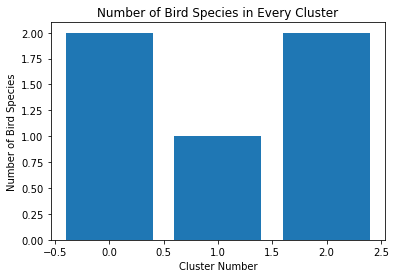

In [16]:
# Number of Bird Species in Every Cluster
print(len(num_bird_species))
cluster_num = range(0,len(num_bird_species))

x = cluster_num 
y = num_bird_species

# Add title, axes
plt.bar(x,y)
plt.title('Number of Bird Species in Every Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Bird Species')

average_num_birds = sum(num_bird_species)/len(num_bird_species)
print("Average number of birds over clusters:", average_num_birds)

In [17]:
### Plot average number of birds over clusters for clusters ranging from 1 to 134

list_num_of_clusters = []
list_of_average_num_birds = []

for n in range(1,130,5):
    list_num_of_clusters.append(n)
    clusters = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward').fit_predict(mfcc_clips)
    num_bird_species = []

    for i in range(len(np.unique(clusters))): 
        cluster_set = set()
        for j in get_clip_indexes(i, clusters):
            
            bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
    #         print(bird_species)
    #         print(type(bird_species))
            cluster_set.add(bird_species)
        num_bird_species.append(len(cluster_set))
            
    average_num_bird_species = sum(num_bird_species)/len(num_bird_species)
    list_of_average_num_birds.append(average_num_bird_species)
    
#     print(list_num_of_clusters)
#     print(list_of_average_num_birds)
    
    

ValueError: Cannot extract more clusters than samples: 16 clusters where given for a tree with 14 leaves.

In [148]:
# Plot spectrogram of all clips in a cluster appended together
plot_spectrogram_of_cluster(samplerate, shorter_clips, 7, clusters, separate_channels=False)

IndexError: too many indices for array

# Visualization

In [ ]:
num_clips = len(shorter_clips)
num_minutes = num_clips / 6
num_hours = num_minutes / 60

def clip_i_to_bin_i(clip_i):
    return int(clip_i / (num_clips/num_minutes))

def time_hist_for_cluster(cluster_i, clusters):
    hist_data = []
    for index in get_clip_indexes(cluster_i, clusters):
        index = clip_i_to_bin_i(index)
        hist_data.append(index)

    plt.ylim(0, (num_clips/num_minutes))
    plt.title('Cluster: %d (%s)' % (cluster_i, cluster_names[cluster_i]))
    plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes])
    plt.show()
    
def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret

def get_clusters_by_cluster_names(clusters, cluster_names):
    uniq_names = np.unique(cluster_names)
    print(uniq_names)
    new_clusters = [-1] * len(clusters)
    for uniq_name_i, uniq_name in enumerate(uniq_names):
        for name_i, name in enumerate(cluster_names):
            if name == uniq_name:
                # Assign name_i to each index in the cluster that has the same index
                for index in range(len(clusters)):
                    if clusters[index] == name_i:
                        new_clusters[index] = uniq_name_i
    return new_clusters

In [ ]:
named_clusters = get_clusters_by_cluster_names(clusters, cluster_names)
Counter(named_clusters).most_common() 
cluster_names_to_plot = np.unique(cluster_names)

# Colors for visualization
jet = pl.get_cmap('jet', len(cluster_names_to_plot))
cluster_colors = {}
for i, name in enumerate(cluster_names_to_plot):
    cluster_colors[name] = jet(i)

Note: These are not real labels for the clusters, this is just a demonstration of the code. The histogram visualization will be replaced with better visualizations for cluster/time data such as Rose Plots.

In [ ]:
def plot_all_histograms(clusters, cluster_names):
    plt.figure(figsize=(15,8))

    for cluster_i in range(len(cluster_names)):
        hist_data = []
        for index in get_clip_indexes(cluster_i, clusters):
            index = clip_i_to_bin_i(index)
            hist_data.append(index)

        cluster_name = cluster_names[cluster_i]
        c = cluster_colors[cluster_name]
        plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes], alpha=0.5, color=c, label=cluster_name)

        plt.ylabel('Number of 10-second audio clips')
        plt.xlabel('Time in Minutes')
        plt.legend(bbox_to_anchor=(1.2, 1.05))
        plt.show()
    
clusters_to_plot = named_clusters
cluster_names_to_plot = np.unique(cluster_names)
plot_all_histograms(named_clusters, np.unique(cluster_names))

### (Optional) testing convert_mp3_to_wav function with one file
This is an extra step that I made to quickly check and troubleshoot the convert_mp3_to_wav function

In [ ]:
dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
file_path = dir_path + 'XC431125 - Rufous Twistwing - Cnipodectes superrufus.mp3'
# file_path = dir_path + 'XC91323 - White-eyed Parakeet - Psittacara leucophthalmus.mp3'

x, fs = convert_mp3_to_wav(file_path, overwrite=True)

In [ ]:
# Graphs to sanity check output of load_audio with online mp3 to wav converter 

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x)

print(x.shape)

# This file is from a random mp3 to wav convert I found here
# https://online-audio-converter.com/ and then downloaded on Desktop
check_dir_path = '/Users/yoo-jin/Desktop/XC431125 - Rufous Twistwing - Cnipodectes superrufus.wav'
x_test, fs_test = sf.read(check_dir_path)

x_test = np.mean(x_test, axis = 1) 
print(x_test.shape)

ax2.plot(x_test)


### Optional: For K-means clustsering 
The function, find_optimal_clusters is used to find the optimal number of clusters for K-means clustering. Take a look at this link for more information: https://hlab.stanford.edu/brian/number_of_clusters_.html.

In [ ]:
## TODO: plot.ly

def find_optimal_clusters(data, min_k, max_k): 
    iters= range(min_k, max_k+1, 2)
    
    sse = [] 
    for k in iters: 
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
    
#     import pandas as pd
#     sse_pct_diff = pd.Series(sse)
#     sse_pct_diff.pct_change()
#     print(sse_pct_diff)
    
    f, ax = plt.subplots(1,1)
    ax.plot(iters, sse, marker = 'o')
    ax.set_xlabel('Cluster Centers')
#     ax.set_xticks(iters)
#     f.autofmt_xdate()
#     ax.set_xtickslabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Number of Clusters')
    
#     ax[0].plot(iters, sse, marker = 'o')
#     ax[0].set_xlabel('Cluster Centers')
# #     ax.set_xticks(iters)
# #     f.autofmt_xdate()
# #     ax.set_xtickslabels(iters)
#     ax[0].set_ylabel('SSE')
#     ax[0].set_title('SSE by Number of Clusters')
    
#     ax[1].plot(iters, sse_pct_diff, marker = 'o')
#     ax[1].set_xlabel('Cluster Centers')
# #     ax.set_xticks(iters)
# #     f.autofmt_xdate()
# #     ax.set_xtickslabels(iters)
#     ax[1].set_ylabel('Percentage Change of SSE')
#     ax[1].set_title('Percentage Change of SSE by Number of Clusters')
    
    plt.tight_layout()

        
# Change the range here: 
find_optimal_clusters(X, 1, 150)

In [ ]:
# dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
dir_path = '/Volumes/Elements/Test/'
samplerate = None
wav_data = []
bird_names_and_lengths = []
num_files = 0

for file in glob.glob(os.path.join(dir_path, '*.mp3')):
#     print(file)
#     convert_mp3_to_wav(file, overwrite=True)
    num_files = num_files+1
    try: 
        data, rate = convert_mp3_to_wav(file, overwrite=True)
#         data = data.astype(int)
        samplerate = rate
        if wav_data == []:
            wav_data = data
        else:
            wav_data = np.concatenate((wav_data, data))
        clip_len = len(data) / samplerate
        
        # Input only bird species
        bird_species = file.split(' - ')[2][:-4].replace(' ', '_')
        bird_names_and_lengths.append([bird_species, clip_len])
#         print(file)
        
        # TO DO: deal with warning, don't suppress
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        warnings.filterwarnings("ignore", category=FutureWarning) 
    except Exception as e:
        print('(failed) ' + file)
        print('\t' + str(e))
        pass
    
print(bird_names_and_lengths)
    
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

### Optional: list all bird species included in the file

In [ ]:
dir_path = '/Volumes/Elements/Test/'
list_of_species = []

for f in glob.glob(os.path.join(dir_path, '*.mp3')): 
    bird_name = os.path.splitext(f)[0].split(" - ", 1)[1].strip()
    if list_of_species == []: 
        list_of_species = [bird_name]
    elif bird_name in list_of_species: 
        pass 
    else: 
        list_of_species.append(bird_name)

print(list_of_species)
# print(len(list_of_species))

In [ ]:
print("shape of wav_data", len(wav_data))
print("sample rate", sr)
print("type of wav_data", type(wav_data))
print('sample rate = %d' % samplerate)
print(wav_data.shape)
length = wav_data.shape[0] / samplerate
print('length = %.1fs' % length)

In [83]:
# loop through all the cluster folders 
from os import listdir
from os.path import isfile, join

# dirname = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/'
dirname = '/Volumes/Elements/Test/Clusters/'
directory_list = os.listdir(dirname)
# print(directory_list)
# make "find . -name ".DS_Store" -delete" in the terminal 

final_bird_list = []
num_bird_species = []

for d in directory_list: 
    path = dirname + d
    file_list = [f for f in os.listdir(path) if not f.startswith('.')]
    
    cluster_set = set()
    for f in file_list: 
#         print(f)
#         if not f.startswith('.'):
        cluster_set = cluster_set | find_bird_species_from_file_name(f)
#         print(f)
    
    num_bird_species.append(len(cluster_set))
    final_bird_list.append(num_bird_species)
        
# print(final_bird_list)
# print(cluster_set)
print(num_bird_species)

XC - White-lined Antbird - Myrmoborus lophotes

XC - White-lined Antbird - Myrmoborus lophotes

XC - White-lined Antbird - Myrmoborus lophotes

XC - Great Jacamar - Jacamerops aureus

XC - Great Jacamar - Jacamerops aureus

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Blue-crowned Trogon - Trogon curucui

XC - Blue-crowned Trogon - Trogon curucui

XC - White-bellied Tody-Tyrant - Hemitriccus griseipectus

[2, 1, 2]
